In [6]:
'''
Notebook to train, evaluate, visualize pointnet model performance.

Credit to Keras architecture to Gary Li detailed in report who references original pointnet paper:

    # C. R. Qi, H. Su, K. Mo, and L. J. Guibas, “PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation,” 
    arXiv:1612.00593[cs.CV], April 10, 2017.
'''

import numpy as np
import os
import tensorflow as tf
import keras
from keras import optimizers
from keras.layers import Input
from keras.models import Model, load_model
from keras.layers import Dense, Flatten, Reshape, Dropout
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Lambda
from keras.utils import np_utils
import h5py


sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
keras.backend.set_session(sess)
keras.backend.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [ ]:
def mat_mul(A, B):
    return tf.matmul(A, B)


def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)


def rotate_point_cloud(batch_data):
    """ Randomly rotate the point clouds to augument the dataset
        rotation is per shape based along up direction
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, rotated batch of point clouds
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data


def jitter_point_cloud(batch_data, sigma=0.01, clip=0.05):
    """ Randomly jitter points. jittering is per point.
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, jittered batch of point clouds
    """
    B, N, C = batch_data.shape
    assert(clip > 0)
    jittered_data = np.clip(sigma * np.random.randn(B, N, C), -1 * clip, clip)
    jittered_data += batch_data
    return jittered_data


# number of points in each sample
num_points = 2048

# number of categories
k = 40

# define optimizer
adam = optimizers.Adam(lr=0.001, decay=0.7)

# ------------------------------------ Pointnet Architecture
# input_Transformation_net
input_points = Input(shape=(num_points, 3))
x = Convolution1D(64, 1, activation='relu',
                  input_shape=(num_points, 3))(input_points)
x = BatchNormalization()(x)
x = Convolution1D(128, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = Convolution1D(1024, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
input_T = Reshape((3, 3))(x)

# forward net
g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)

# feature transform net
f = Convolution1D(64, 1, activation='relu')(g)
f = BatchNormalization()(f)
f = Convolution1D(128, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = Convolution1D(1024, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)

# forward net
g = Lambda(mat_mul, arguments={'B': feature_T})(g)
g = Convolution1D(64, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(128, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(1024, 1, activation='relu')(g)
g = BatchNormalization()(g)

# global_feature
global_feature = MaxPooling1D(pool_size=num_points)(g)

# point_net_cls
c = Dense(512, activation='relu')(global_feature)
c = BatchNormalization()(c)
c = Dropout(rate=0.2)(c)
c = Dense(256, activation='relu')(c)
c = BatchNormalization()(c)
c = Dropout(rate=0.2)(c)
c = Dense(k, activation='softmax')(c)
prediction = Flatten()(c)
# --------------------------------------------------end of pointnet

# print the model summary
model = Model(inputs=input_points, outputs=prediction)
print(model.summary())

# load train points and labels
path = os.path.dirname(os.path.realpath("Group28_19SP_ECE228"))
train_path = os.path.join(path, "PrepData")
filenames = [d for d in os.listdir(train_path)]
print(train_path)
print(filenames)
train_points = None
train_labels = None
for d in filenames:
    cur_points, cur_labels = load_h5(os.path.join(train_path, d))
    cur_points = cur_points.reshape(1, -1, 3)
    cur_labels = cur_labels.reshape(1, -1)
    if train_labels is None or train_points is None:
        train_labels = cur_labels
        train_points = cur_points
    else:
        train_labels = np.hstack((train_labels, cur_labels))
        train_points = np.hstack((train_points, cur_points))
train_points_r = train_points.reshape(-1, num_points, 3)
train_labels_r = train_labels.reshape(-1, 1)

# load test points and labels
test_path = os.path.join(path, "PrepData_test")
filenames = [d for d in os.listdir(test_path)]
print(test_path)
print(filenames)
test_points = None
test_labels = None
for d in filenames:
    cur_points, cur_labels = load_h5(os.path.join(test_path, d))
    cur_points = cur_points.reshape(1, -1, 3)
    cur_labels = cur_labels.reshape(1, -1)
    if test_labels is None or test_points is None:
        test_labels = cur_labels
        test_points = cur_points
    else:
        test_labels = np.hstack((test_labels, cur_labels))
        test_points = np.hstack((test_points, cur_points))
test_points_r = test_points.reshape(-1, num_points, 3)
test_labels_r = test_labels.reshape(-1, 1)


# label to categorical
Y_train = np_utils.to_categorical(train_labels_r, k)
Y_test = np_utils.to_categorical(test_labels_r, k)

# compile classification model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit model on training data
#for i in range(1,50):
    #model.fit(train_points_r, Y_train, batch_size=32, epochs=1, shuffle=True, verbose=1)
    # rotate and jitter the points
train_points_rotate = rotate_point_cloud(train_points_r)
train_points_jitter = jitter_point_cloud(train_points_rotate)
history = model.fit(train_points_jitter, Y_train,validation_split = 0.2, batch_size=32, epochs=50, shuffle=True, verbose=1)
model.save_weights('model_weights_02dropout.h5')
import pickle
with open('trainHistoryDict_02dropout', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    #s = "Current epoch is:" + str(i)
    #print(s)
    #if i % 5 == 0:
        #score = model.evaluate(test_points_r, Y_test, verbose=1)
        #print('Test loss: ', score[0])
        #print('Test accuracy: ', score[1])

# score the model
score = model.evaluate(test_points_r, Y_test, verbose=1)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])


In [8]:
x, d = load_h5(os.path.join(train_path, 'ply_data_train0.h5'))

In [9]:
'''Get class dictionary'''
shapenames_file_dir = 'shape_names.txt'

def get_class_dict(shapenames_file_dir):
    with open(shapenames_file_dir) as file:
        file_contents = file.read()
        shape_names = file_contents.split()
        class_dict = {i:v for i,v in enumerate(shape_names)}
    return class_dict

class_dict = get_class_dict(shapenames_file_dir)

<IPython.core.display.Javascript object>


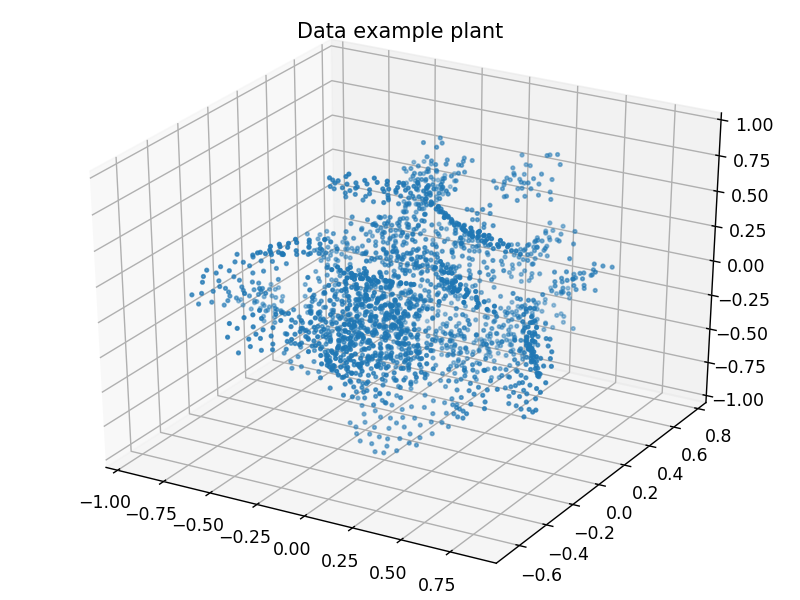

In [10]:
'''Visualize dataset example'''
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

idx=23

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x[idx,:,0].flatten(),x[idx,:,1].flatten(),x[idx,:,2].flatten(), '.',s=4)
ax.set_title("Data example " + class_dict[d[idx][0]])
plt.show()

<IPython.core.display.Javascript object>


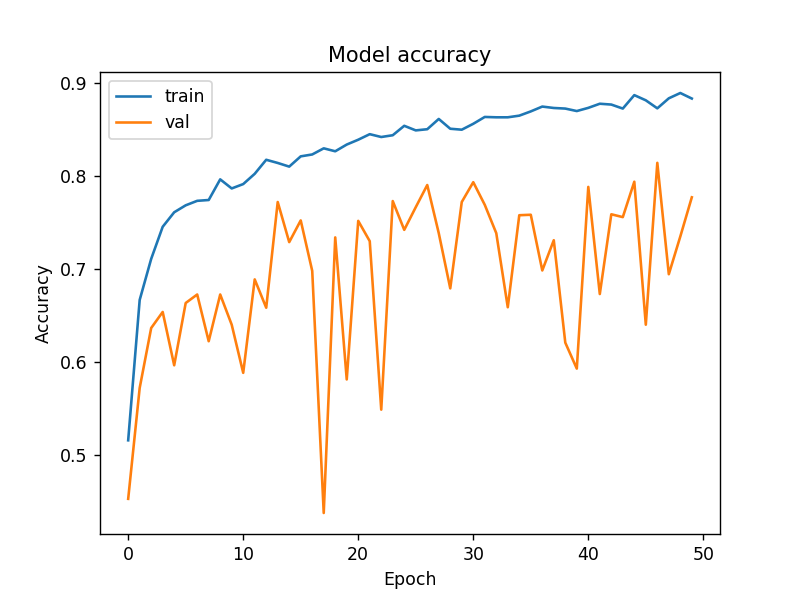

<IPython.core.display.Javascript object>


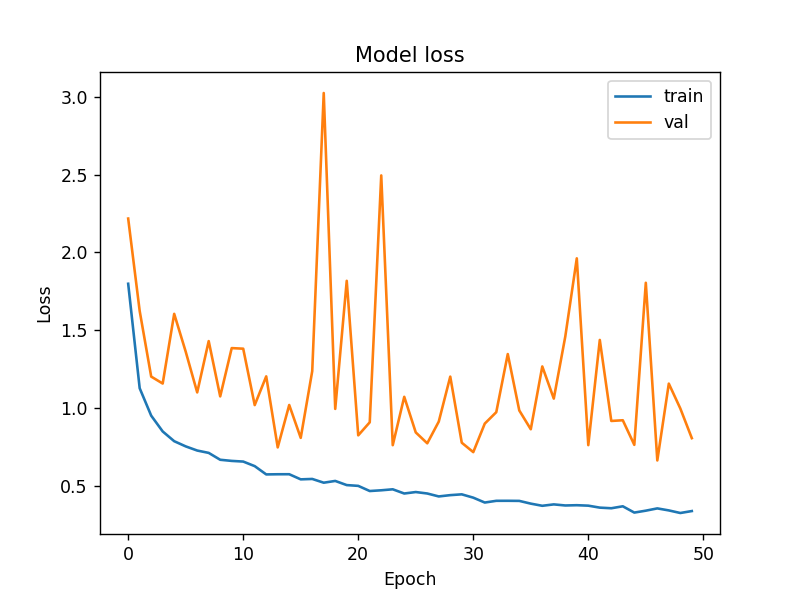

In [11]:
'''Visualize loss/acc plots from saved experiment'''
import pickle
import matplotlib.pyplot as plt
file = open("trainHistoryDict_02dropout",'rb')
history = pickle.load(file)
fig = plt.figure()
# Plot training & validation accuracy values
plt.plot(np.arange(len(history['acc'])), history['acc'], label= 'train')
plt.plot(np.arange(len(history['val_acc'])), history['val_acc'], label = 'val')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

fig = plt.figure()
# Plot training & validation loss values
plt.plot(np.arange(len(history['loss'])), history['loss'], label = 'train')
plt.plot(np.arange(len(history['val_loss'])), history['val_loss'], label = 'val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Test set accuracy with dropout 0.2: 72.4%

<IPython.core.display.Javascript object>


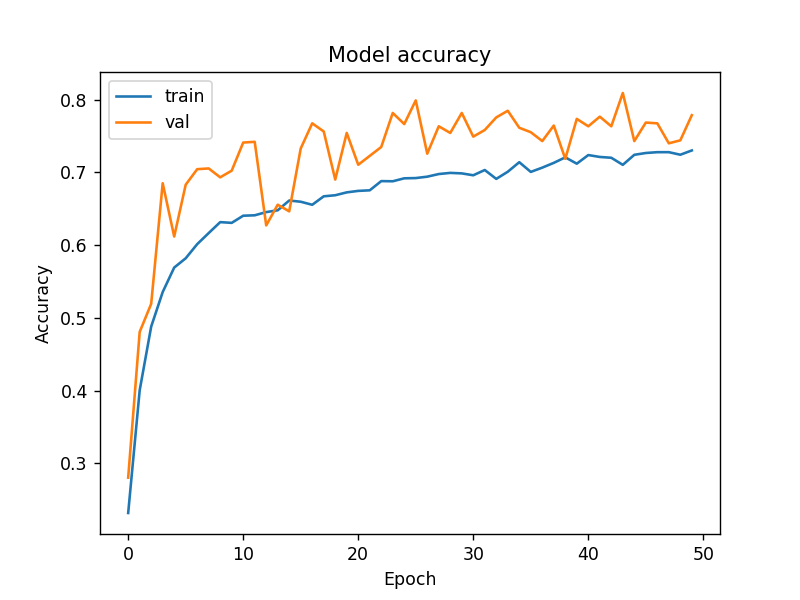

<IPython.core.display.Javascript object>


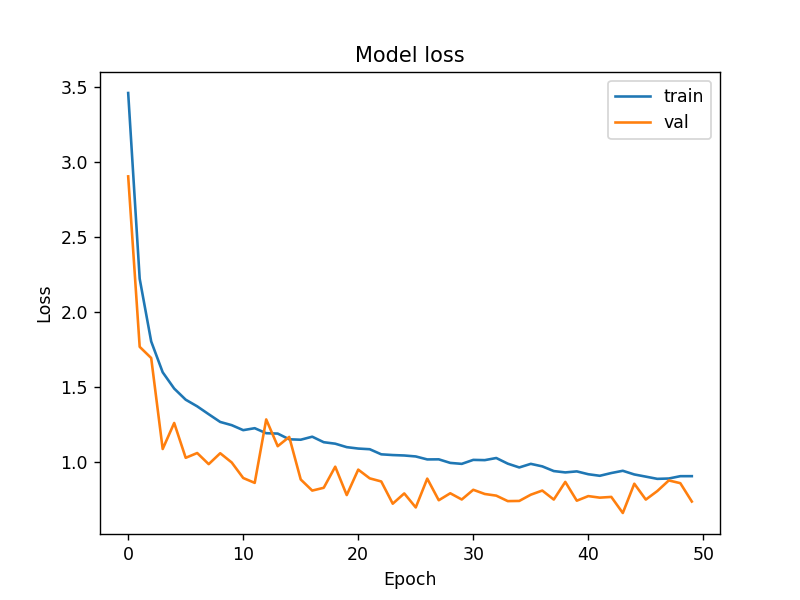

In [12]:
'''Visualize loss/acc plots from saved experiments'''
import pickle
import matplotlib.pyplot as plt
file = open("trainHistoryDict",'rb')
history = pickle.load(file)
fig = plt.figure()
# Plot training & validation accuracy values
plt.plot(np.arange(len(history['acc'])), history['acc'], label= 'train')
plt.plot(np.arange(len(history['val_acc'])), history['val_acc'], label = 'val')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

fig = plt.figure()
# Plot training & validation loss values
plt.plot(np.arange(len(history['loss'])), history['loss'], label = 'train')
plt.plot(np.arange(len(history['val_loss'])), history['val_loss'], label = 'val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Test set accuracy with dropout 0.7: 76.2%

In [13]:
'''Load trained model'''
model = Model(inputs=input_points, outputs=prediction)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.load_weights("model_weights_02dropout.h5")


<IPython.core.display.Javascript object>


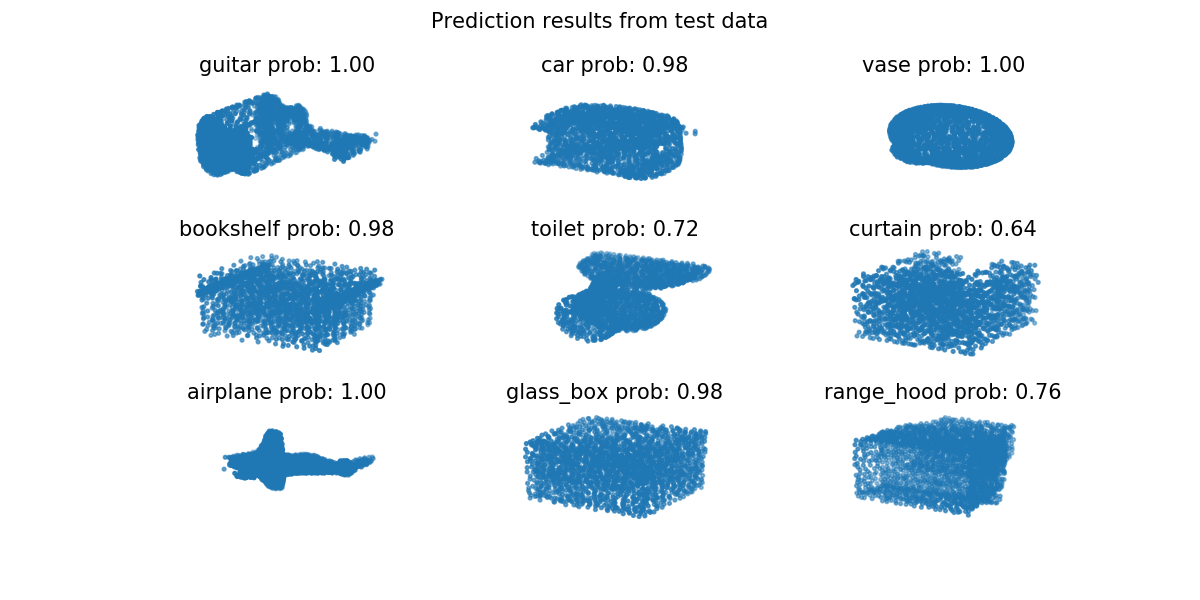

Text(0.5, 0.98, 'Prediction results from test data')

In [14]:
'''Show predictions and scores from test set'''
fig = plt.figure(figsize=plt.figaspect(0.5))
path = os.path.dirname(os.path.realpath("Group28_19SP_ECE228"))
test_path = os.path.join(path, "PrepData_test")
filenames = [d for d in os.listdir(test_path)]
x, d = load_h5(os.path.join(test_path, 'ply_data_test0.h5'))
for i in range(3):
    for j in range(3):
        idx = np.random.randint(2047)
        prediction = model.predict(x[idx][np.newaxis,:,:], batch_size=1)
        class_score = np.max(prediction)
        class_prediction = np.argmax(prediction)
        ax = fig.add_subplot(3, 3, 1+3*i+j, projection='3d')
        ax.scatter(x[idx,:,0].flatten(),x[idx,:,1].flatten(),x[idx,:,2].flatten(), '.',s=4)
        ax.set_title(class_dict[class_prediction] + " prob: %.2f" % class_score)
        ax.axis('off')
fig.suptitle("Prediction results from test data")
        

In [ ]:
#Testing evaluation
test_path = os.path.join(path, "PrepData_test")
filenames = [d for d in os.listdir(test_path)]
print(test_path)
print(filenames)
test_points = None
test_labels = None
for d in filenames:
    cur_points, cur_labels = load_h5(os.path.join(test_path, d))
    cur_points = cur_points.reshape(1, -1, 3)
    cur_labels = cur_labels.reshape(1, -1)
    if test_labels is None or test_points is None:
        test_labels = cur_labels
        test_points = cur_points
    else:
        test_labels = np.hstack((test_labels, cur_labels))
        test_points = np.hstack((test_points, cur_points))
test_points_r = test_points.reshape(-1, num_points, 3)
test_labels_r = test_labels.reshape(-1, 1)
Y_test = np_utils.to_categorical(test_labels_r, k)
score = model.evaluate(test_points_r, Y_test, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

In [16]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(test_points_r)
cm = confusion_matrix(test_labels_r, predictions.argmax(axis=1))

In [17]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = [i for i in list(class_dict.values())],
                  columns = [i for i in list(class_dict.values())])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 5}, cmap= 'plasma')

<IPython.core.display.Javascript object>

dict_values(['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone', 'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp', 'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink', 'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox'])